1D viscoplastic with damage model
======================================

1 . Additive Strain decomposition

$$ \varepsilon = \varepsilon^e + \varepsilon^p   \tag{1}$$

2 . Constitutive law

$$ \ sigma = (1 - D)E\varepsilon^e \tag{2}$$

Where E is the Young's Modulus.

3 . Yield function

$$ f(\sigma, R,\chi ,D) = |\sigma - \chi| - (R \sigma_{yo}) \tag{3}$$

4 . Assossiative plastic flow rule

$$ \dot{\varepsilon}^p = \dot{\lambda}\frac{\partial f}{\partial \sigma}   \tag{4}$$

$$ \dot{p} = |\dot{\varepsilon}^p| \tag{5} $$

5 . Evolution law for $\dot{p}$

$$
    \dot{p} = 
\begin{cases}
    \ln\bigg[ \bigg( 1-\frac{f(\sigma, R,\chi ,D)}{k_{inf}}\bigg)\bigg]^{-\mu},& \text{if } f\geq 0\\
    0,              & \text{otherwise}
\end{cases}
\tag{6}$$

6 . Isotropic and cinamatic hardening evolution laws.

$$ \dot{R} = b(R_{inf} - R)\dot{\lambda} \tag{7} $$

$$ \dot{\chi} = \gamma(\chi_{inf}\dot{\varepsilon}^p - \chi\dot{\lambda}) \tag{8} $$

7 . Damage evolution law

$$ \dot{D} = \frac{Y}{S}\dot{p}H(p - pd) \tag{9} $$

Where H is the Heaviside step function and Y is defined as:

$$ Y = \frac{\sigma^2}{2E(1-D)^2} \tag{10}$$


Constitutive Initial value problem
==================
Elastic Trial State and Return Mapping Algorithm
---------------------


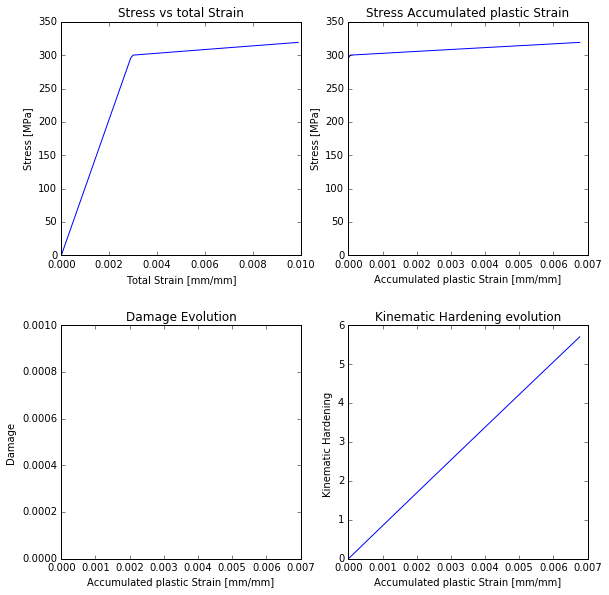

<function __main__.testecase1>

In [38]:
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import root
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.html.widgets import *

%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)

# Material properties
#E = 200.0e3 # young modulus in MPA
#sygma0 = 350.0 # initial yield stress in MPA
#M = 2. 
#Kinf = 1000.
#b = 10.
#Rinf = 300.
#gamma = 1.
#Xinf = 100.
#S = 100.
#pd = 0.5


def Hookelaw(e,D,propmat):
    ''' Calculates de stress as
    sigma = (1-D)*E*e
    '''
    E = propmat.E
    sygma0 = propmat.sygma0
    M = propmat.M
    Kinf = propmat.Kinf
    b = propmat.b
    Rinf = propmat.Rinf
    gamma = propmat.gamma
    Xinf = propmat.Xinf
    S = propmat.S
    pd = propmat.pd
    
    s = (1.0 - D)*E*e
    
    return s
    
def yieldFunction(s,R,X,D,propmat):
    E = propmat.E
    sygma0 = propmat.sygma0
    M = propmat.M
    Kinf = propmat.Kinf
    b = propmat.b
    Rinf = propmat.Rinf
    gamma = propmat.gamma
    Xinf = propmat.Xinf
    S = propmat.S
    
    f = abs(s - X)- R -sygma0
    return f

def Heaviside(x):
    if x>0.0:
        return 1.0
    else:
        return 0.0
    

def elasticTrial(en1,an,propmat):
    ''' This functions get the total strain deformation at n+1 (en1) and the internal variables at n (an)
        and return the yield function trial, stress trial at n+1 (sn1) and the internal variables trial at n + 1
        
        where an = {epn,p,Rn,Xn,Dn}
    '''
    
    epn,pn,Rn,Xn,Dn = an
    
    # strain trial
    etrial = en1 - epn
    
    # stress trial
    strial = Hookelaw(etrial,Dn,propmat)
    
    # yield trial
    ftrial = yieldFunction(strial,Rn,Xn,Dn,propmat)
    
    an1trial = epn,pn,Rn,Xn,Dn
    
    return ftrial, strial, an1trial, etrial

class PropMat(object):
    def __init__(self, E, sygma0, M , Kinf, b, Rinf, gamma, Xinf, S, pd):
        self.E = E
        self.sygma0 = sygma0
        self.M = M
        self.Kinf = Kinf
        self.b = b
        self.Rinf = Rinf
        self.gamma = gamma
        self.Xinf = Xinf
        self.S = S
        self.pd = pd
        

def residualF(x0, propmat,dt):
    ''' The variables an must be created before call this function
    x0 = deltaL,sn1,Rn1,Xn1,Dn1
    '''
    
    # getting material properties
    E = propmat.E
    sygma0 = propmat.sygma0
    M = propmat.M
    Kinf = propmat.Kinf
    b = propmat.b
    Rinf = propmat.Rinf
    gamma = propmat.gamma
    Xinf = propmat.Xinf
    S = propmat.S
    pd = propmat.pd
    
    deltaL,sn1,Rn1,Xn1,Dn1 = x0
    epn,pn,Rn,Xn,Dn = an
    fn1 = yieldFunction(sn1/(1.0-Dn1),Rn1,Xn1,Dn1,propmat)
    en1 = etrial - deltaL*np.sign(sn1/(1.0-Dn1)-Xn1)/(1.0-Dn1)
    Yn1= sn1**2/(2.0*E*(1.0-Dn1)**2)
    pn1 = pn + deltaL/(1.0-Dn1)
    
    R1 = deltaL/(1.0 - Dn1) + M*np.log((1.0-(fn1/Kinf)))*dt
    R2 = sn1 - (1.0 - Dn1)*E*en1
    R3 = Rn1 - Rn - b*(Rinf - Rn1)*deltaL
    R4 = Xn1 - Xn - gamma*(Xinf*np.sign(sn1/(1.0-Dn1) - Xn1)/(1.0-Dn1) - Xn1)*deltaL
    R5 = Dn1 - Dn - Yn1*Heaviside(pn1 - pd)*deltaL/(1.0-Dn1)
    
    #print "log =", np.log((1.0-(fn1/Kinf)))
    F = np.array([R1,R2,R3,R4,R5])
    return F

def jacobianJ(x0, propmat,dt):
    ''' This method calculates the jacobian matrix of the residual function
    return KT numpy matrix
    '''
    # getting material properties
    E = propmat.E
    sygma0 = propmat.sygma0
    M = propmat.M
    Kinf = propmat.Kinf
    b = propmat.b
    Rinf = propmat.Rinf
    gamma = propmat.gamma
    Xinf = propmat.Xinf
    S = propmat.S
    pd = propmat.pd
    
    #getting constitutive variables
    deltaL,Sn1,Rn1,Xn1,Dn1 = x0
    epn,pn,Rn,Xn,Dn = an
    pn1 = pn + deltaL/(1.0-Dn1)
    
    # yield function and auxiliary variables
    fn1 = yieldFunction(Sn1/(1.0-Dn1),Rn1,Xn1,Dn1,propmat)
    aux = 1.0 - fn1/Kinf
    bux = 1.0/aux
    signal = np.sign(Sn1/(1.0-Dn1)-Xn1)
    Dn13=(1.0-Dn1)*(1.0-Dn1)*(1.0-Dn1) 
    HPn1 = Heaviside(pn1 - pd)
    
    KT = np.zeros((5,5))                 
    # derivatives                  
    KT[0][0] = -M*dt*bux*signal/((1.0-Dn1)*Kinf)
    KT[0][1] = 1.0/(1.0-Dn1)                      
    KT[0][2] = M*dt*bux/Kinf
    KT[0][3] = M*dt*bux*signal/Kinf
    KT[0][4] = deltaL/((1.0-Dn1)*(1.0-Dn1))-M*dt*bux*signal*Sn1/((1.0-Dn1)*(1.0-Dn1)*Kinf)
    
    KT[1][0] = 1.0
    KT[1][1] = E*signal
    KT[1][2] = 0.0
    KT[1][3] = 0.0
    KT[1][4] = E*etrial
                  
    KT[2][0] = 0.0
    KT[2][1] = -b*(Rinf-Rn1)
    KT[2][2] = 1.0 + b*deltaL
    KT[2][3] = 0.0
    KT[2][4] = 0.0
               
    KT[3][0] = 0.0
    KT[3][1] = -gamma*((Xinf*signal)/(1.0 - Dn1) - Xn1)
    KT[3][2] = 0.0
    KT[3][3] = 1.0+gamma*deltaL
    KT[3][4] = -gamma*deltaL*Xinf*signal/((1.0-Dn1)*(1.0-Dn1))
                  
    KT[4][0] = -Sn1*HPn1*deltaL/(S*E*Dn13)
    KT[4][1] = -Sn1*Sn1*HPn1/(2.0*S*E*Dn13)
    KT[4][2] = 0.0
    KT[4][3] = 0.0
    KT[4][4] = 1.0 - 3.0*Sn1*Sn1*HPn1*deltaL/(2.0*S*E*Dn13*(1.0-Dn1))              
    
    return np.matrix(KT)
                    
def testecase1(E, sygma0, M , Kinf, b, Rinf, gamma, Xinf, S, pd,dt):
    global etrial, an
    # teste case 1
    en1 = 0.00
    epn = 0.0
    pn = 0.0
    Rn = 0.0
    Xn = 0.0
    Dn = 0.0
    an = epn,pn,Rn,Xn,Dn
    #dt = 0.01
    de = 0.0001

    nint = 100
    
    data = []
    propmat = PropMat(E, sygma0, M , Kinf, b, Rinf, gamma, Xinf, S, pd)
        
    for i in range(nint):

        # check elastic trial state
        ftrial, strial, an1trial, etrial = elasticTrial(en1,an,propmat)

        #print("ftrial = %f" %ftrial)
        #print("strial = %f" %strial)
        if ftrial<0.0:
            sn1 = strial
            an1 = an1trial
            epn1,pn1,Rn1,Xn1,Dn1 = an1
        else:
            deltaL = 0.0
            sn1 = strial
            Rn1 = Rn
            Xn1 = Xn
            Dn1 =  Dn
            x0 = np.array([deltaL,sn1,Rn1,Xn1,Dn1])
            #R = residualF(x0, propmat,dt)
            #xsol, info, ier, msg = fsolve(residualF,x0,full_output=1)
            J = lambda x0: jacobianJ(x0,propmat,dt) # Jacobian matrix      
            sol = root(lambda x0: residualF(x0,propmat,dt), x0, method='lm', tol=1e-12)
            deltaL,sn1,Rn1,Xn1,Dn1 = sol.x
            if sol.success == False:
                print(sol.success)
                
            pn1 = pn + deltaL/(1.0 - Dn1)
            epn1 = epn + deltaL*np.sign(sn1-Xn1)
            sn = sn1
            Rn = Rn1
            an1 = epn1,pn1,Rn1,Xn1,Dn1


        # store solution    
        #print np.array([en1,sn1,epn,pn1,Rn1,Xn1,Dn1])
        data.append([en1,sn1,epn1,pn1,Rn1,Xn1,Dn1])

        #update internal variables
        an = an1
        pn = pn1
        epn = epn1

        # next iteration
        en1 = en1 + de
        #print(en1)
    #---------------------------------
    #plot results
    e = [x[0] for x in data]
    s = [x[1] for x in data]
    ep = [x[2] for x in data]
    Dn = [x[6] for x in data]
    Xn = [x[5] for x in data]

    #f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(8,8),dpi= 80)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8),dpi= 80)
    f.tight_layout()
    plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
    
    ax1.plot(e,s)    
    ax1.set_ylabel('Stress [MPa]')  
    ax1.set_xlabel('Total Strain [mm/mm]')  
    ax1.set_title('Stress vs total Strain')    

    
    ax2.plot(ep,s)    
    ax2.set_ylabel('Stress [MPa]')  
    ax2.set_xlabel('Accumulated plastic Strain [mm/mm]')  
    ax2.set_title('Stress Accumulated plastic Strain')    

    
    ax3.plot(ep,Dn)    
    ax3.set_ylabel('Damage ')  
    ax3.set_xlabel('Accumulated plastic Strain [mm/mm]')  
    ax3.set_title('Damage Evolution')   
    ax3.set_ylim(0., max([2.0*np.max(Dn),1e-3]))
    
    ax4.plot(ep,Xn)    
    ax4.set_ylabel('Kinematic Hardening ')  
    ax4.set_xlabel('Accumulated plastic Strain [mm/mm]')  
    ax4.set_title('Kinematic Hardening evolution')   
    
    plt.show()


interact(testecase1,  E = (5e3,200.0e3,1e3), sygma0= (100,500,10), M= (10,100,1), 
         Kinf= (500,1000,10), b= (2,10,1), Rinf= (200,500,20), gamma= (0.1,5,0.1), 
         Xinf= (200,500,20), S= (50,200,10), pd  = (0.005,0.5,0.01),dt = (0.000005,0.1,0.00001))     